=== Funnel de Conversión a Nivel de Cliente (por paso) ===
variation    Control       Test
start      99.454758  99.050757
step_1     85.544340  90.103554
step_2     79.154650  82.533145
step_3     73.918529  77.312309
confirm    65.248738  68.949557


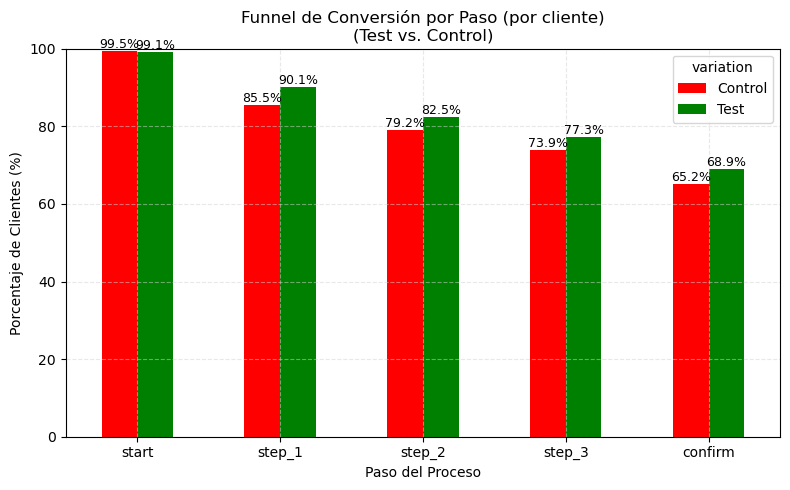

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------
# PASO 1: Cargar el DataFrame ya procesado
# --------------------------------------------------
df = pd.read_csv("../../data/processed/navegacion_clientes_experimento_limpio.csv")

# Asegurarse de filtrar para los grupos válidos (Test y Control)
df = df[df["variation"].isin(["Test", "Control"])].copy()

# --------------------------------------------------
# PASO 2: Agrupar a nivel de cliente
# --------------------------------------------------
# Para cada cliente (client_id) y su grupo (variation), determinamos si alcanzó cada paso.
# Definimos los pasos del proceso:
steps = ["start", "step_1", "step_2", "step_3", "confirm"]

# Construimos una lista de registros, uno por cliente, con indicadores booleanos para cada paso.
client_records = []
for (variation, client_id), group in df.groupby(["variation", "client_id"]):
    record = {"variation": variation, "client_id": client_id}
    # Para cada paso, verificamos si el cliente tuvo al menos un registro con ese paso
    for step in steps:
        record[step + "_reached"] = group["process_step"].eq(step).any()
    client_records.append(record)

df_clients = pd.DataFrame(client_records)

# --------------------------------------------------
# PASO 3: Calcular el funnel de conversión a nivel de cliente
# --------------------------------------------------
# Para cada grupo (variation) y cada paso, calculamos la tasa (proporción) de clientes que lo alcanzaron.
# Debido a que los indicadores son booleanos, la media equivale a la proporción.
funnel_data = {}
for step in steps:
    col = step + "_reached"
    # Agrupar por variation y calcular la media de ese indicador
    prop = df_clients.groupby("variation")[col].mean() * 100  # convertir a porcentaje
    funnel_data[step] = prop

# Convertir el diccionario a DataFrame, donde las filas son los pasos y las columnas los grupos.
funnel_df = pd.DataFrame(funnel_data).T
# Aseguramos que las filas estén en el orden deseado
funnel_df = funnel_df.reindex(steps)

print("=== Funnel de Conversión a Nivel de Cliente (por paso) ===")
print(funnel_df)

# --------------------------------------------------
# PASO 4: Graficar el funnel de conversión
# --------------------------------------------------
# Definir colores personalizados: Control en rojo y Test en verde.
color_map = {"Control": "red", "Test": "green"}
colors = [color_map.get(col, "gray") for col in funnel_df.columns]

fig, ax = plt.subplots(figsize=(8, 5))
funnel_df.plot(kind="bar", ax=ax, color=colors, legend=True)

ax.set_title("Funnel de Conversión por Paso (por cliente)\n(Test vs. Control)")
ax.set_xlabel("Paso del Proceso")
ax.set_ylabel("Porcentaje de Clientes (%)")
ax.set_ylim(0, 100)
ax.grid(True, which='major', axis='both', color='lightgray', linestyle='--', alpha=0.5)

# Añadir etiquetas con el porcentaje sobre cada barra
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.annotate(f"{height:.1f}%",
                    (p.get_x() + p.get_width()/2, height),
                    ha="center", va="bottom", fontsize=9)

plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("../../img/cr_drop-off_funnel.png")
plt.show()
